# Import


In [2]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


# LOAD DATA 

## Labélisation des données

In [104]:
df = pd.read_csv('datasetiot.csv')
df_revershell = pd.read_csv('revershell.csv')
df_keylogger = pd.read_csv('dataset_keylog.csv')
# keep 100 000 first rows
df = df.iloc[:100000]
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
df_revershell['label'] = np.nan
df_revershell['label'] = df_revershell['label'].astype('category')
df_keylogger['label'] = np.nan
df_keylogger['label'] = df_keylogger['label'].astype('category')

# set label for df_revershell and df_keylogger
df_revershell.loc[:, 'label'] = 'Reverse Shell'
# duplicate 5 times the reverse shell dataset
df_revershell = df_revershell.append([df_revershell] * 8, ignore_index=True)
df_keylogger.loc[:, 'label'] = 'Keylogger'

#set category types
df['label'].cat.set_categories(['Normal', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'Normal'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'Normal'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:28000, 'label'] = 'Normal'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'Normal'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'Normal'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'

df_copy = df.copy()
reverse_shell_packets = df.loc[df['label'] == 'Reverse Shell']
duplicated_reverse_shell_packets = reverse_shell_packets.copy()
duplicated_reverse_shell_packets['No.'] = df['No.'].max() + np.arange(1, len(duplicated_reverse_shell_packets) + 1)
duplicated_reverse_shell_packets['Time'] = df['Time'].max() + np.arange(1, len(duplicated_reverse_shell_packets) + 1)
df_copy = df_copy.append(duplicated_reverse_shell_packets, ignore_index=True)



# duplicate paquet labelised as Reverse Shell and put it at the end of the dataset




C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\1560228301.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_revershell.loc[:, 'label'] = 'Reverse Shell'
C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\1560228301.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_revershell = df_revershell.append([df_revershell] * 8, ignore_index=True)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\1560228301.py:18: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  

In [98]:
time_diff = df['Time'].diff()

# Calculate mean time difference
mean_time_diff = time_diff.mean()

# Print the result
print(f"The mean time evolution between 2 packets is {mean_time_diff}")

The mean time evolution between 2 packets is 0.08740466184847848


In [ ]:
# find mean evolution of column time for reverse shell label and keylogger label
df_copy['Time'] = pd.to_datetime(df_copy['Time'], unit='s')


In [129]:
# show labels for protocol DNS
df.loc[df['Protocol'] == 'DNS', 'label'].value_counts()

Series([], Name: label, dtype: int64)

In [5]:
# show labels for protocol  FTP, and TLSv1 and TLSv1.2 and SSDP AND FTP-DATA
# df.loc[df['Protocol'].isin(['FTP', 'TLSv1', 'TLSv1.2', 'SSDP', 'FTP-DATA']), 'label'].value_counts()
# # class these protocols as normal
# df.loc[df['Protocol'].isin(['FTP', 'TLSv1', 'TLSv1.2', 'SSDP', 'FTP-DATA']), 'label'] = 'Normal'

In [105]:
# concatenate the 3 dataframes
df = pd.concat([df, df_revershell, df_keylogger], ignore_index=True)
# make the column No. as a iteration  (+1 +1 +1 +1 ) start as 1
df['No.'] = np.arange(1, len(df) + 1)

## Quelques visualisations

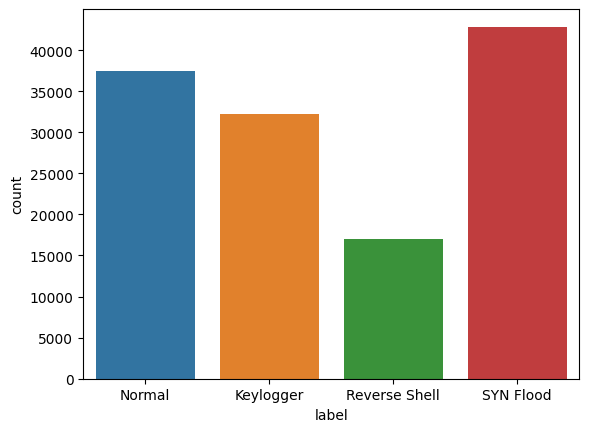

In [107]:
# plot diffrent features
# plot the distribution of the label
sns.countplot(x='label', data=df)
plt.show()
    

In [127]:
# show how many packets are in total
print(f"Total number of packets: {len(df)}")
# print how many packets are in each label
print(df['label'].value_counts())


Total number of packets: 129458
3    42849
1    37450
0    32181
2    16978
Name: label, dtype: int64


In [8]:
# print all features
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


## Preprocessing


In [9]:
# preprocess the data
# drop the columns that are not needed "No" , "Time"
#df = df.drop(['No.', 'Time'], axis=1)


In [108]:
 # show 20 last rows
print(df.tail(20))

           No.        Time          Source     Destination Protocol  Length  \
129438  129439  281.374603      172.16.0.4  172.16.208.128      TCP      66   
129439  129440  281.374714  172.16.208.128      172.16.0.4      TCP      66   
129440  129441  281.375445  172.16.208.128      172.16.0.4      TCP      66   
129441  129442  281.375808      172.16.0.4  172.16.208.128      TCP      66   
129442  129443  281.431554      172.16.0.4  172.16.208.128      TCP      74   
129443  129444  281.431625  172.16.208.128      172.16.0.4      TCP      74   
129444  129445  281.432382      172.16.0.4  172.16.208.128      TCP      66   
129445  129446  281.432658      172.16.0.4  172.16.208.128      TCP      67   
129446  129447  281.432670      172.16.0.4  172.16.208.128      TCP      66   
129447  129448  281.432903  172.16.208.128      172.16.0.4      TCP      66   
129448  129449  281.433686  172.16.208.128      172.16.0.4      TCP      66   
129449  129450  281.434160      172.16.0.4  172.16.2

In [109]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

df_copy['label'] = label_encoder.fit_transform(df_copy['label'])

# convert categorical data to numerical data
df['Protocol'] = df['Protocol'].astype('category')
df['Protocol'] = df['Protocol'].cat.codes
df['Source'] = df['Source'].astype('category')
df['Source'] = df['Source'].cat.codes
df['Destination'] = df['Destination'].astype('category')
df['Destination'] = df['Destination'].cat.codes
df['Info'] = df['Info'].astype('category')
df['Info'] = df['Info'].cat.codes
df.head()

df_copy['Protocol'] = df_copy['Protocol'].astype('category')
df_copy['Protocol'] = df_copy['Protocol'].cat.codes
df_copy['Source'] = df_copy['Source'].astype('category')
df_copy['Source'] = df_copy['Source'].cat.codes
df_copy['Destination'] = df_copy['Destination'].astype('category')
df_copy['Destination'] = df_copy['Destination'].cat.codes
df_copy['Info'] = df_copy['Info'].astype('category')
df_copy['Info'] = df_copy['Info'].cat.codes
df_copy.head()


# label_encoders = {}
# for column in df.columns:
#     if df[column].dtype == type(object):
#         label_encoders[column] = LabelEncoder()
#         df[column] = label_encoders[column].fit_transform(df[column])

# df.head()


,No.,Time,Source,Destination,Protocol,Length,Info,label
0,1,0.000000,10155,11194,13,166,76629,1
1,2,0.060725,10155,11194,13,171,76629,1
2,3,-0.001392,8070,11194,13,166,76629,1
3,4,0.060623,8070,11194,13,171,76629,1
4,5,10.001488,10155,11194,13,166,76629,1


In [110]:
df.dtypes

No.              int32
Time           float64
Source           int16
Destination      int16
Protocol          int8
Length           int64
Info             int32
label            int32
dtype: object

In [111]:
# vlaue count of label
df['label'].value_counts()

3    42849
1    37450
0    32181
2    16978
Name: label, dtype: int64

## Création des données d'entrainement et de test

In [152]:
import pandas as pd
import numpy as np

def format_data_time_step(data, time_step):
    """
    Format time-series data into a format suitable for training a recurrent neural network.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the time-series data. The DataFrame should contain a 'label' column
        and one or more feature columns.

    time_step : int
        The number of time steps (i.e., rows) to include in each sample.

    Returns
    -------
    tuple
        A tuple containing the following six elements in the order given:

        train_data : numpy.ndarray
            An array of shape (n_samples_train, time_step, n_features) containing the training data.

        train_labels : numpy.ndarray
            An array of shape (n_samples_train,) containing the training labels.

        val_data : numpy.ndarray
            An array of shape (n_samples_val, time_step, n_features) containing the validation data.

        val_labels : numpy.ndarray
            An array of shape (n_samples_val,) containing the validation labels.

        test_data : numpy.ndarray
            An array of shape (n_samples_test, time_step, n_features) containing the test data.

        test_labels : numpy.ndarray
            An array of shape (n_samples_test,) containing the test labels.

    Notes
    -----
    This function splits the data into training, validation, and test sets and reshapes the data into
    samples of length `time_step`. The training set includes the first 70% of the data, the validation
    set includes the next 15%, and the test set includes the final 15%. But this is totally arbitrary so dont realy take in account
    """
    unique_labels = data['label'].unique()

    train_df = pd.DataFrame(columns=data.columns)
    val_df = pd.DataFrame(columns=data.columns)
    test_df = pd.DataFrame(columns=data.columns)

    for label in unique_labels:
        label_df = data[data['label'] == label]
        train_samples = label_df.iloc[:int(len(label_df) * 0.80)]
        val_samples = label_df.iloc[int(len(label_df) * 0.80):int(len(label_df) * 0.90)]
        test_samples = label_df.iloc[int(len(label_df) * 0.90):]

        train_df = train_df.append(train_samples)
        val_df = val_df.append(val_samples)
        test_df = test_df.append(test_samples)

    #train df 

    # Define a function to reshape the input data into the required format for LSTM models
    def reshape_data(data):
        data_list = []
        for i in range(len(data) - time_step + 1):
            data_list.append(data[i:i+time_step, :])
        return np.array(data_list)

    # Reshape the training data and extract the labels
    train_data = reshape_data(train_df.drop(['label'], axis=1).to_numpy())
    train_labels = train_df['label'].iloc[time_step-1:].to_numpy()

    # Reshape the validation data and extract the labels
    val_data = reshape_data(val_df.drop(['label'], axis=1).to_numpy())
    val_labels = val_df['label'].iloc[time_step-1:].to_numpy()

    # Reshape the test data and extract the labels
    test_data = reshape_data(test_df.drop(['label'], axis=1).to_numpy())
    test_labels = test_df['label'].iloc[time_step-1:].to_numpy()

    train_data = train_data.astype('float32')
    train_labels = train_labels.astype('float32')
    val_data = val_data.astype('float32')
    val_labels = val_labels.astype('float32')
    test_data = test_data.astype('float32')
    test_labels = test_labels.astype('float32')
    return train_data, train_labels, val_data, val_labels, test_data, test_labels



In [155]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = format_data_time_step(df, 100)

# print the shape of every data with their name
print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)
print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)
print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)






C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\2123225512.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_samples)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\2123225512.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_df = val_df.append(val_samples)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\2123225512.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_samples)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_23100\2123225512.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_samples)
C:\Users\enzoh\AppData\Local\

train_data shape:  (103466, 100, 7)
train_labels shape:  (103466,)
val_data shape:  (12847, 100, 7)
val_labels shape:  (12847,)
test_data shape:  (12848, 100, 7)
test_labels shape:  (12848,)


In [156]:
# print value count of every label
print('train_labels value count: ', pd.Series(train_labels).value_counts())
print('val_labels value count: ', pd.Series(val_labels).value_counts())
print('test_labels value count: ', pd.Series(test_labels).value_counts())


train_labels value count:  3.0    34279
1.0    29861
0.0    25744
2.0    13582
dtype: int64
val_labels value count:  3.0    4285
1.0    3646
0.0    3218
2.0    1698
dtype: int64
test_labels value count:  3.0    4285
1.0    3646
0.0    3219
2.0    1698
dtype: int64


In [157]:
total_len = len(train_data) + len(val_data) + len(test_data)
print('total_len: ', total_len)

total_len:  129161


# LES MODELS LALALALA 

In [158]:
num_labels = len(np.unique(train_labels))
print(num_labels)


4


In [159]:
input_shape = (train_data.shape[1], train_data.shape[2])

In [160]:
# create the model
simple_lstm_model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=input_shape),
    keras.layers.Dense(num_labels, activation='softmax')
])

simple_lstm_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

simple_lstm_model.summary()

# model with 4 LSTM layers
model_stacked_lstm = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(num_labels, activation='softmax')
])

model_stacked_lstm.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_stacked_lstm.summary()


# cnn model FOR NETWORK TRAFFIC
model_cnn = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(num_labels, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


# model CNN + LSTM
model_cnn_lstm = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(64),
    keras.layers.Dense(num_labels, activation='softmax')
])

model_cnn_lstm.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_cnn_lstm.summary()

# model CNN + LSTM + LSTM
model_cnn_lstm_stacked = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64,return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(num_labels, activation='softmax')
])


model_cnn_lstm_stacked.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_bidirectional_LSTM = keras.Sequential()
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), input_shape=input_shape))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_bidirectional_LSTM.add(keras.layers.Dense(num_labels, activation='softmax'))
model_bidirectional_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidirectional_LSTM.summary()

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_rnn.add(keras.layers.SimpleRNN(64, return_sequences=True))
model_rnn.add(keras.layers.SimpleRNN(64))
model_rnn.add(keras.layers.Dense(32, activation='relu'))
model_rnn.add(keras.layers.Dense(num_labels, activation='softmax'))
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()



model_rnn_lstm = keras.Sequential()
model_rnn_lstm.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_rnn_lstm.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_rnn_lstm.add(keras.layers.SimpleRNN(64, return_sequences=True))
model_rnn_lstm.add(keras.layers.LSTM(64))
model_rnn_lstm.add(keras.layers.Dense(32, activation='relu'))
model_rnn_lstm.add(keras.layers.Dense(num_labels, activation='softmax'))
model_rnn_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn_lstm.summary()





CNN2D_LSTM = keras.Sequential()
# conv 2D layer 
CNN2D_LSTM.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
CNN2D_LSTM.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
CNN2D_LSTM.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
CNN2D_LSTM.add(keras.layers.Dropout(0.25))
# time distributed layer for output of conv2D
CNN2D_LSTM.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
# LSTM layer
CNN2D_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
CNN2D_LSTM.add(keras.layers.LSTM(64))
CNN2D_LSTM.add(keras.layers.Dense(32, activation='relu'))
CNN2D_LSTM.add(keras.layers.Dense(num_labels, activation='softmax'))
CNN2D_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN2D_LSTM.summary()


model_list = [model_stacked_lstm, model_cnn, model_cnn_lstm, model_cnn_lstm_stacked, model_bidirectional_LSTM, model_rnn, model_rnn_lstm, CNN2D_LSTM]


Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_285 (LSTM)             (None, 128)               69632     
                                                                 
 dense_265 (Dense)           (None, 4)                 516       
                                                                 
Total params: 70,148
Trainable params: 70,148
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_286 (LSTM)             (None, 100, 128)          69632     
                                                                 
 lstm_287 (LSTM)             (None, 100, 128)          131584    
                                                                 
 lstm_288 (LSTM)        

In [149]:
model_name = ['model_stacked_lstm', 'model_cnn', 'model_cnn_lstm', 'model_cnn_lstm_stacked', 'model_bidirectional_LSTM', 'model_rnn', 'model_rnn_lstm', 'CNN2D_LSTM']

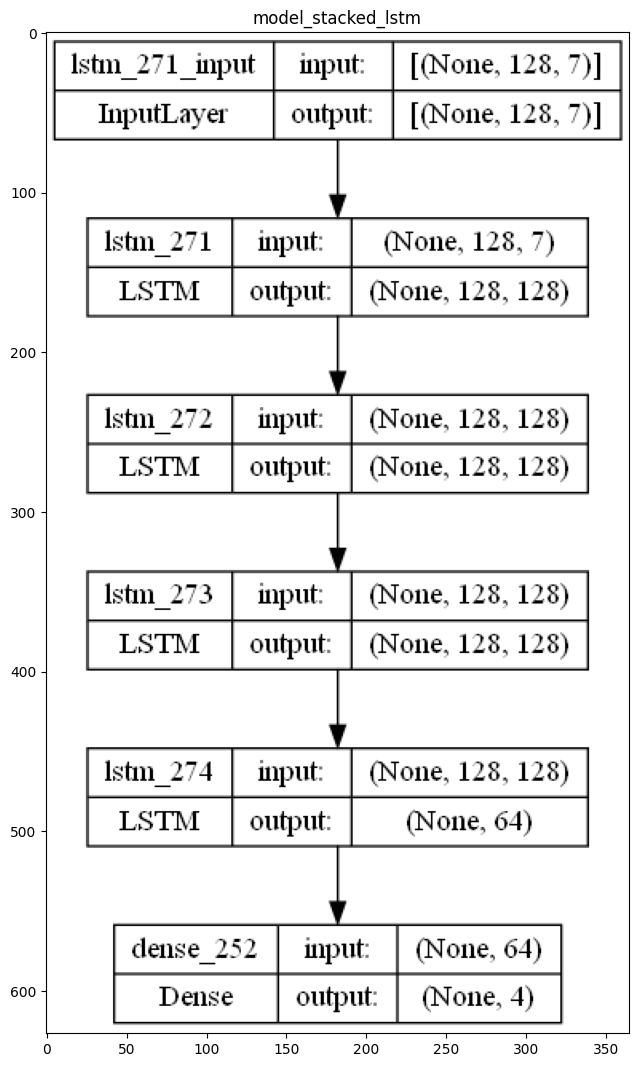

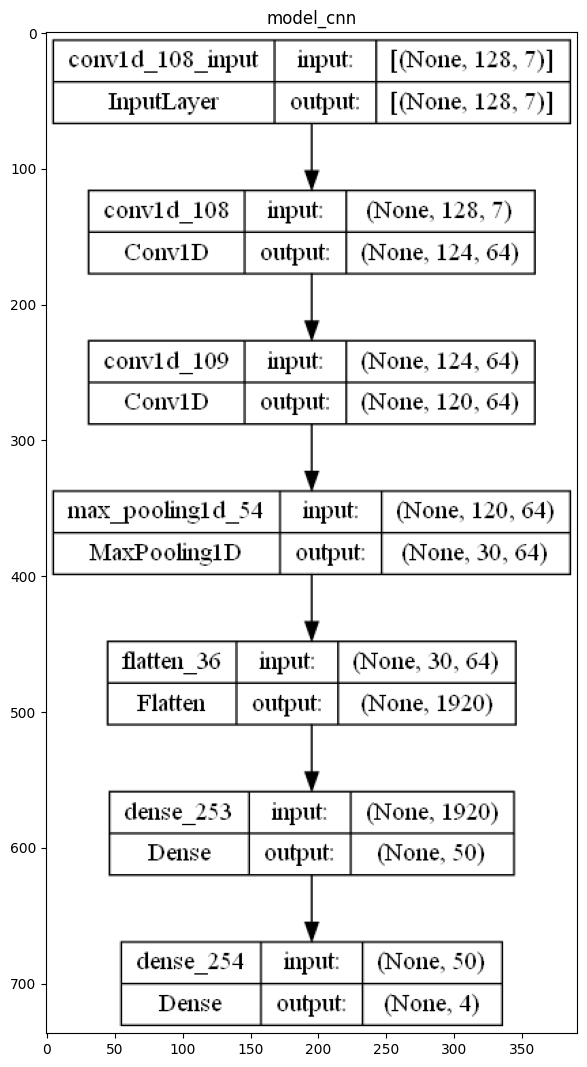

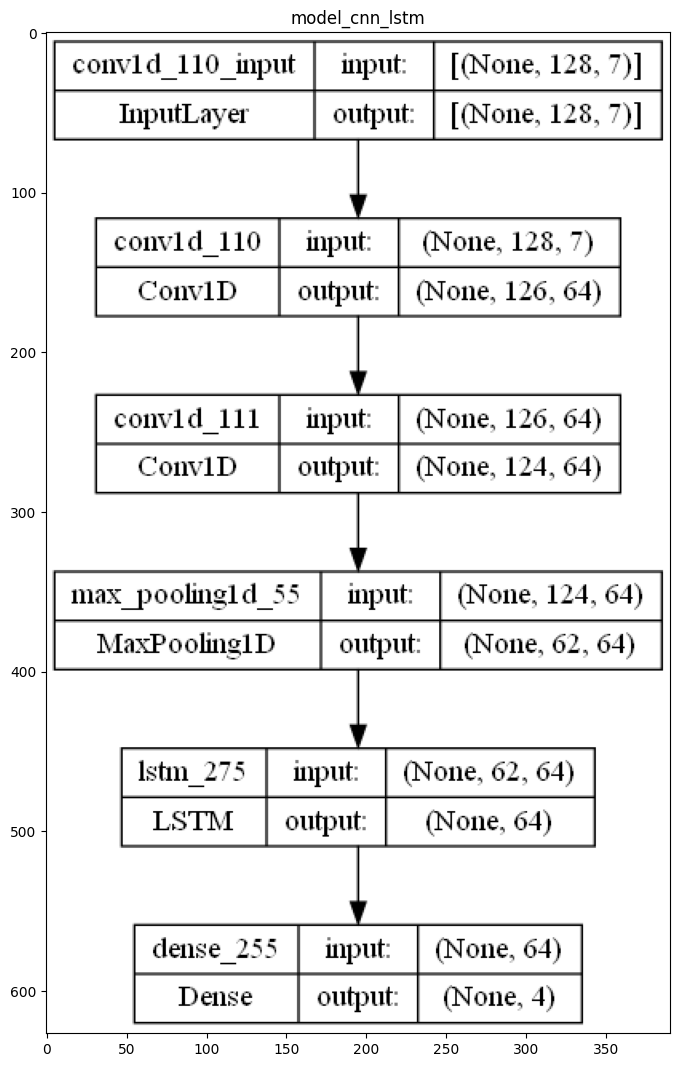

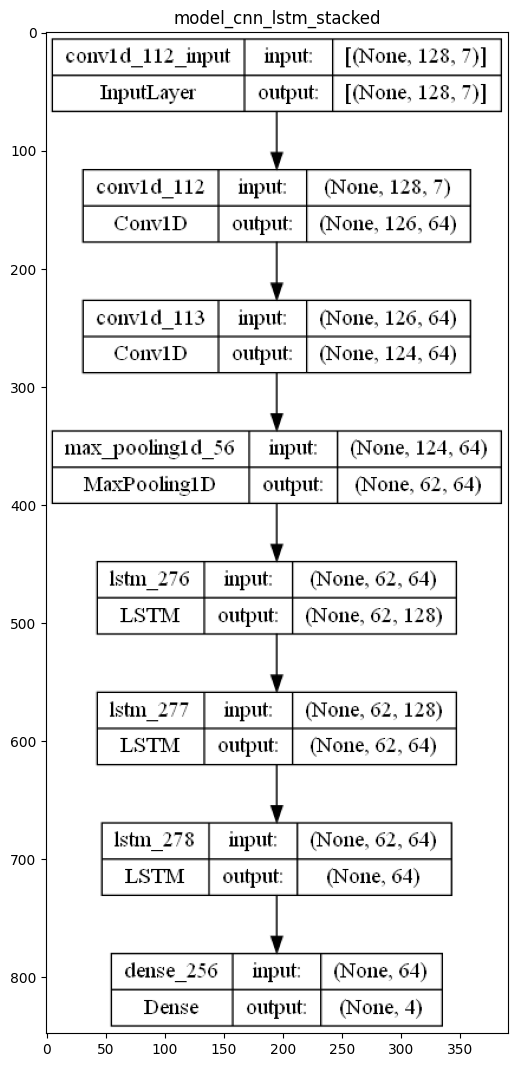

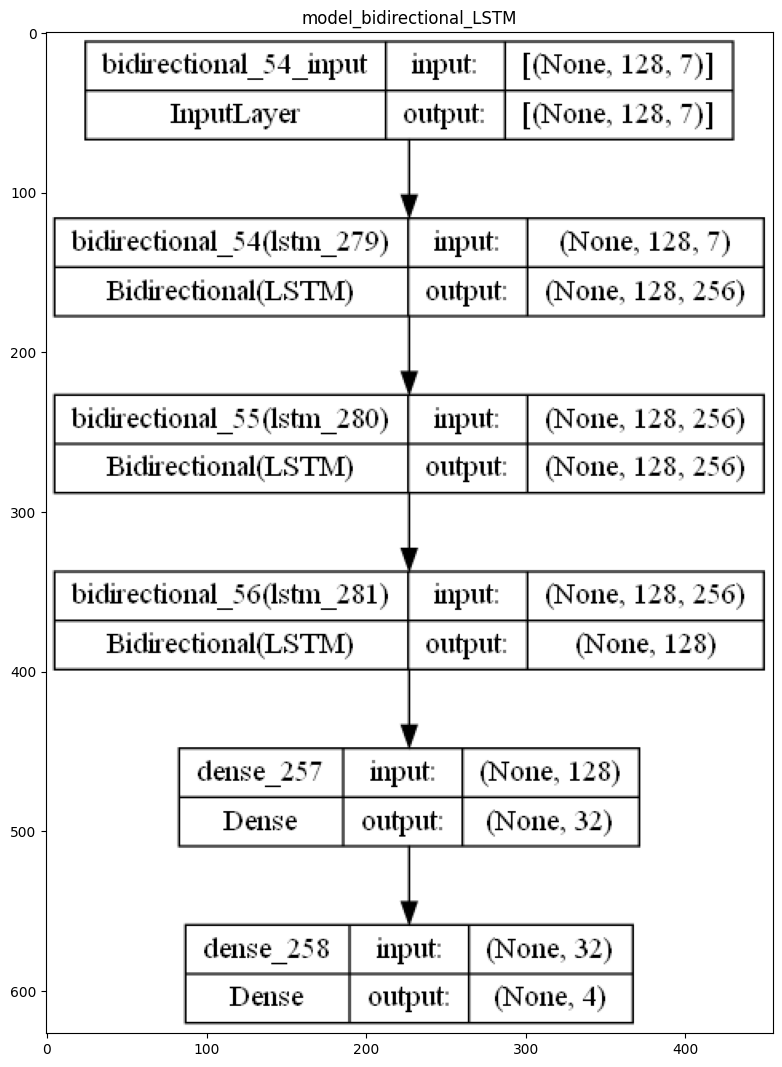

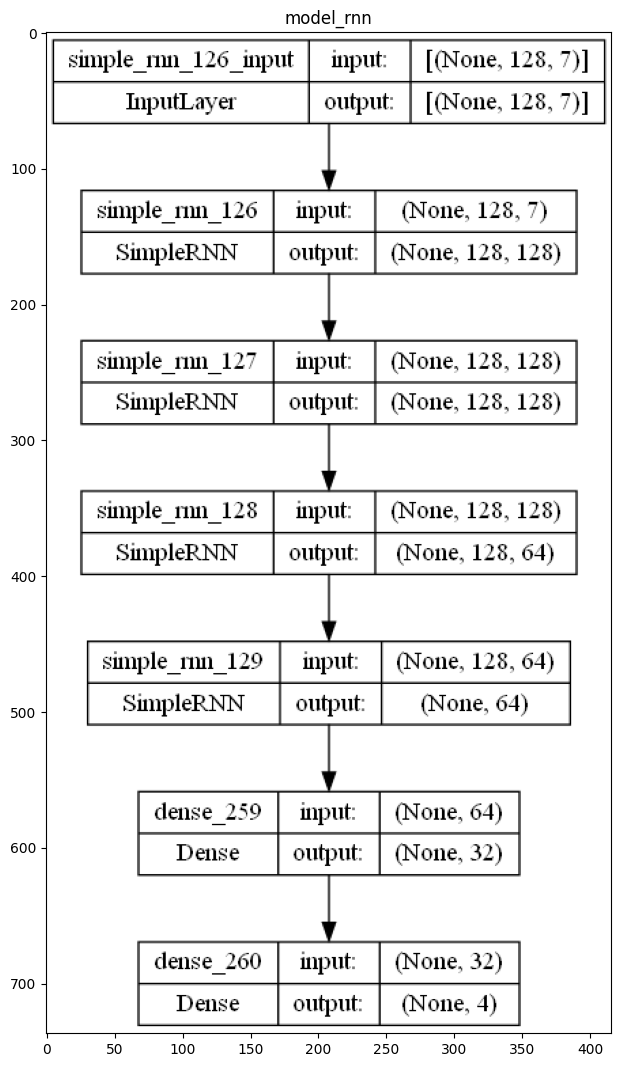

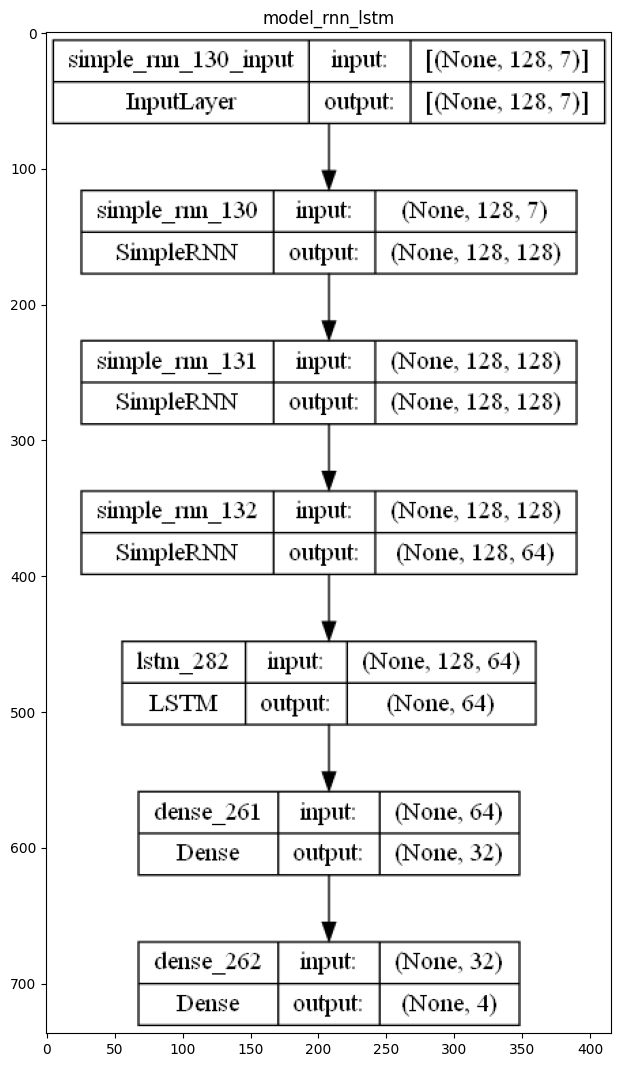

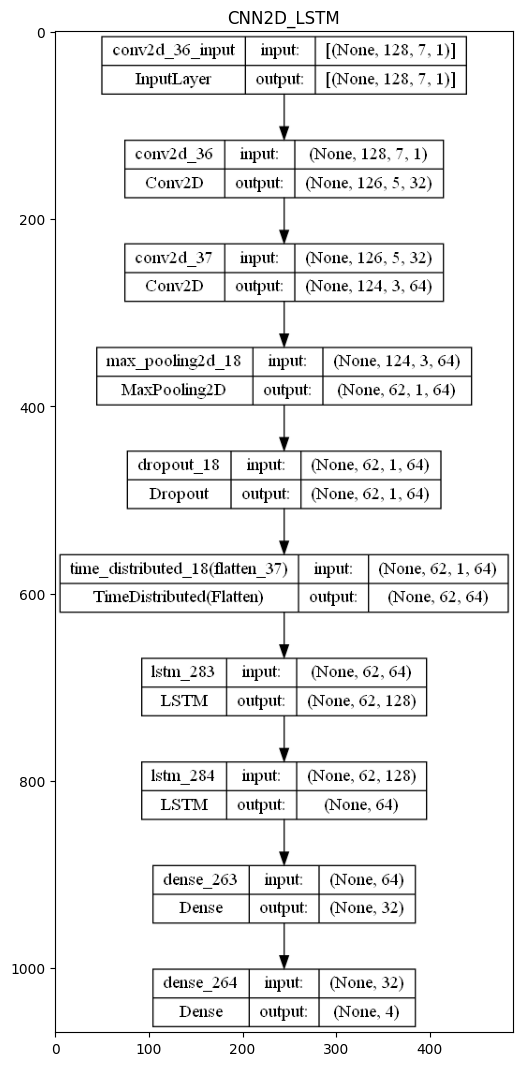

In [150]:
# import plot_model
from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

for model in model_list:
    name = model_name[model_list.index(model)]
    plot_model(model, to_file=f'{name}_plot.png', show_shapes=True, show_layer_names=True)
    img = mpimg.imread(f'{name}_plot.png')
    plt.figure(figsize=(13, 13))
    plt.title(name) # add the model name as the title of the image
    imgplot = plt.imshow(img)
    plt.show()

In [161]:
history_simple_lstm = simple_lstm_model.fit(train_data, train_labels, epochs=15,batch_size=256 ,validation_data=(val_data, val_labels))
history_stacked_lstm = model_stacked_lstm.fit(train_data, train_labels, epochs=15,batch_size=256 ,validation_data=(val_data, val_labels))
history_cnn = model_cnn.fit(train_data, train_labels, epochs=15,batch_size=128 ,validation_data=(val_data, val_labels))
history_cnn_lstm = model_cnn_lstm.fit(train_data, train_labels, epochs=15,batch_size=256 ,validation_data=(val_data, val_labels))
history_cnn_lstm_stacked = model_cnn_lstm_stacked.fit(train_data, train_labels, epochs=25,batch_size=256 ,validation_data=(val_data, val_labels))
history_bidirectional_LSTM = model_bidirectional_LSTM.fit(train_data, train_labels, epochs=15,batch_size=256 ,validation_data=(val_data, val_labels))
history_rnn_lstm = model_rnn_lstm.fit(train_data, train_labels, epochs=15,batch_size=256 ,validation_data=(val_data, val_labels))
history_CNN2D_LSTM = CNN2D_LSTM.fit(train_data, train_labels, epochs=15,batch_size=256 ,validation_data=(val_data, val_labels))



Epoch 1/15
405/405 [==============================] - 6s 12ms/step - loss: 0.6097 - accuracy: 0.7851 - val_loss: 0.7275 - val_accuracy: 0.7249
Epoch 2/15
405/405 [==============================] - 5s 12ms/step - loss: 0.2565 - accuracy: 0.9382 - val_loss: 0.7592 - val_accuracy: 0.6330
Epoch 3/15
405/405 [==============================] - 5s 12ms/step - loss: 0.1767 - accuracy: 0.9581 - val_loss: 0.4846 - val_accuracy: 0.7655
Epoch 4/15
405/405 [==============================] - 5s 12ms/step - loss: 0.1582 - accuracy: 0.9608 - val_loss: 0.4933 - val_accuracy: 0.7687
Epoch 5/15
405/405 [==============================] - 4s 11ms/step - loss: 0.1361 - accuracy: 0.9663 - val_loss: 0.4738 - val_accuracy: 0.7960
Epoch 6/15
405/405 [==============================] - 5s 12ms/step - loss: 0.1041 - accuracy: 0.9769 - val_loss: 0.3906 - val_accuracy: 0.8400
Epoch 7/15
405/405 [==============================] - 5s 13ms/step - loss: 0.0933 - accuracy: 0.9785 - val_loss: 0.3403 - val_accuracy: 0.8970

In [65]:
# save model
CNN2D_LSTM.save('CNN2D_LSTM.h5')

In [98]:
def plot_model_loss_accuracy(history,model_name):
  """ Plot the model loss and accuracy for training and validation data

  Args:
      history (keras.callbacks.History): History object returned by model.fit()
      model_name (str): Name of the model
  """
  plt.plot(history.history['accuracy'],label="Training Accuracy")
  plt.plot(history.history['val_accuracy'],label="Validation Accuracy")

  plt.plot(history.history['loss'],label="Training Loss")
  plt.plot(history.history['val_loss'],label="Validation Loss")
  # plot the max validation accuracy
  max_val_acc = max(history.history['val_accuracy'])
  max_val_acc_epoch = history.history['val_accuracy'].index(max_val_acc)
  plt.plot(max_val_acc_epoch, max_val_acc, marker='o', markersize=5, color="red")
  plt.annotate("Max Validation Accuracy: {:.2f}%".format(max_val_acc*100), (max_val_acc_epoch, max_val_acc), xytext=(max_val_acc_epoch, max_val_acc+0.05), arrowprops=dict(facecolor='black', shrink=0.05))
  plt.title('Training and Validation Accuracy/Loss for ' + model_name)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy/Loss')
  # limit the y axis to 0.5 to 5
  plt.ylim(0.5,5)
  plt.legend()
  plt.show()

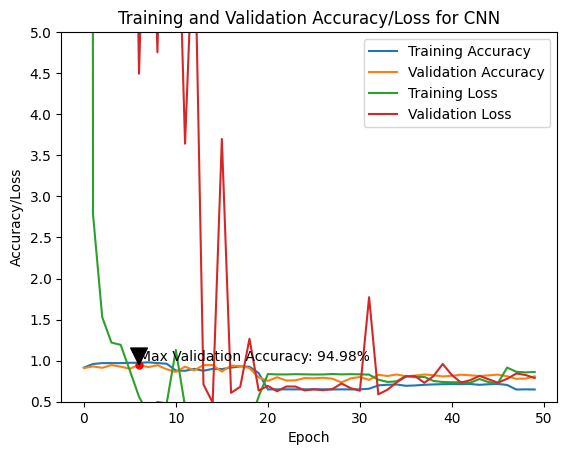

In [104]:
plot_model_loss_accuracy(history_cnn, 'CNN')

In [124]:
# evaluate the model on test data
score = model_cnn_lstm_stacked.evaluate(test_data, test_labels, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
# F1 score
from sklearn.metrics import f1_score
y_pred = model_cnn_lstm_stacked.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
print("F1 score:", f1_score(test_labels, y_pred, average='macro'))




936/936 [==============================] - 7s 8ms/step - loss: 2.8304 - accuracy: 0.6789
Test loss: 2.830374240875244
Test accuracy: 0.6789042949676514
936/936 [==============================] - 7s 7ms/step
F1 score: 0.6702399411791127


936/936 [==============================] - 7s 7ms/step


ValueError: <keras.engine.sequential.Sequential object at 0x000001BBCED76500> is not in list

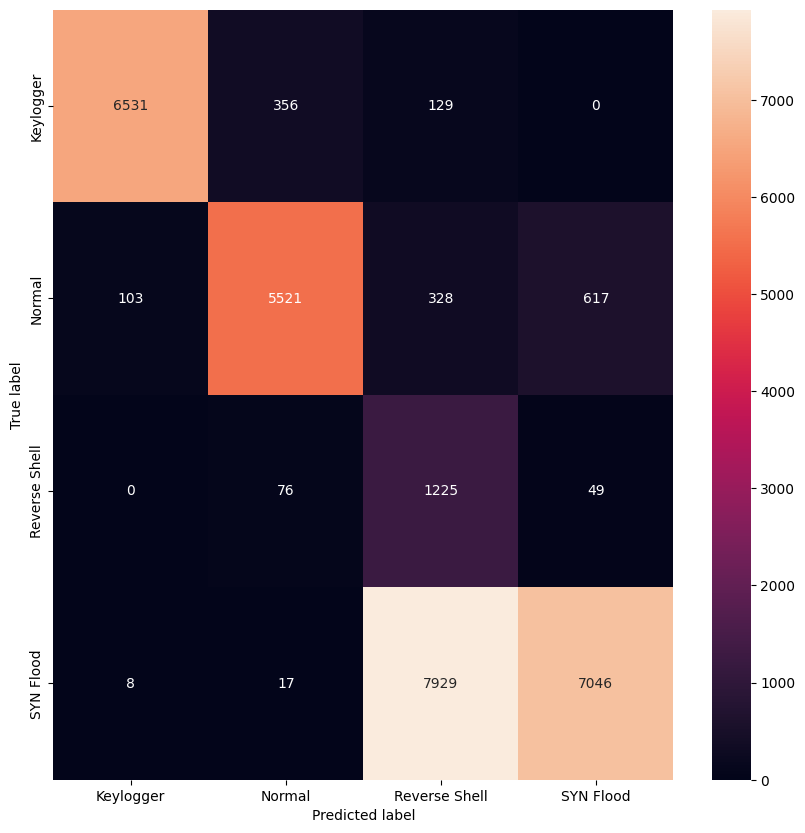

In [125]:
# confusion matrix on test data with original labels with label_encoder
def plot_confusion_matrix(model):
    import itertools
from sklearn.metrics import confusion_matrix


y_pred = model_cnn_lstm_stacked.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Create a DataFrame from the confusion matrix using the label names
cm_df = pd.DataFrame(cm, columns=label_encoder.classes_, index=label_encoder.classes_)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
# plot with the name of the model
plt.title(f'Confusion Matrix for {model_name[model_list.index(model)]}')

